In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
treino = pd.read_csv('train.csv')
teste = pd.read_csv('test.csv')

In [4]:
#Identificar o tipo da variavel e as primeiras linhas da tabela treino
display(treino.dtypes)
display(treino.head())

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
#Verificando as colunas que possuem valores vazios
treino.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
#Verificando como os dados estão distribuidos 
treino.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
#Analisar as probabilidades de cada sexo sobreviver
treino[['Sex', 'Survived']].groupby(['Sex']).mean()

,Survived
Sex,
female,0.742038
male,0.188908


<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

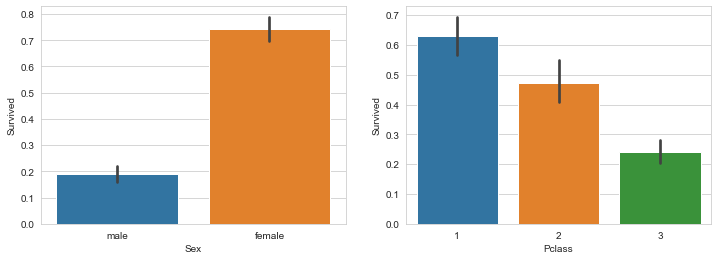

In [8]:
#Graficos mostrando a relação dos que sobreviveram em realçaõ ao sexo e a classe que ocupavam no navio
fig, (axis1, axis2) = plt.subplots(1,2, figsize=(12,4))

sns.barplot(x='Sex', y='Survived', data=treino, ax=axis1)
sns.barplot(x='Pclass', y='Survived', data=treino, ax=axis2)

C:\Users\breno\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\breno\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


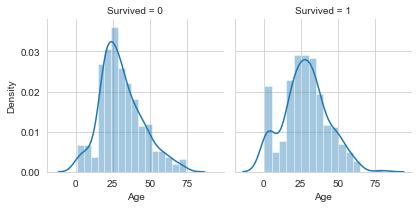

In [9]:
#Essse grafico mostra a idade das pessoas que sobreviveram e que morreram
#0 sobreviveu 1 nao sobreviveu
idade_sobreviveu = sns.FacetGrid(treino, col='Survived')
idade_sobreviveu.map(sns.distplot, 'Age')

In [10]:
#Mostrando a correlação entre os atributos
treino.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [11]:
# salvar os índices dos datasets para recuperação posterior
treino_idx = treino.shape[0]
teste_idx = teste.shape[0]

# salvar PassengerId
id_passagem = teste['PassengerId']

# extrair coluna 'Survived' e excluir ela do dataset treino
alvo = treino.Survived.copy()
treino.drop(['Survived'], axis=1, inplace=True)

#Juntando as duas tabelas em uma só
base_titanic = pd.concat(objs=[treino, teste], axis=0).reset_index(drop=True)

In [12]:
display(base_titanic)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [13]:
#Excluindo as colunas da tabela, pois não será nnecessaria no treinamento do modelo
base_titanic.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [14]:
#Verificar e tratar os valores nulos
base_titanic.isnull().sum()

Pclass        0
Sex           0
Age         263
SibSp         0
Parch         0
Fare          1
Embarked      2
dtype: int64

In [17]:
#Tratando os valores vazios nas colunas

# Irei completar as idades faltantes com a mediana, para nao ficar vazio
idade_mediana = base_titanic['Age'].median()
base_titanic['Age'].fillna(idade_mediana, inplace=True)

# Irei completar as tarifas faltantes com a mediana, para nao ficar vazio
tarifa_mediana = base_titanic['Fare'].median()
base_titanic['Fare'].fillna(tarifa_mediana, inplace=True)

# Irei completar o embarque com o local onde mais teve passageiros embarcando
porto_embarque = base_titanic['Embarked'].value_counts()[0]
base_titanic['Embarked'].fillna(porto_embarque, inplace=True)

In [18]:
#Tratar as variaveis, transforma o sexo dos passageiros em numeros
#GRAFICO: MASCULINO = 0, FEMININO = 1

base_titanic['Sex'] = base_titanic['Sex'].map({'male': 0, 'female': 1})

In [19]:
#Utilizei variaveis dummies para informa se o passageiro embarcou ou não no porto 
#ADICIONANDO TODOS OS POTNSO DE EMBARQUE NA TABELA
porto_embarque = pd.get_dummies(base_titanic['Embarked'], prefix='Embarked')
base_titanic = pd.concat([base_titanic, porto_embarque], axis=1)
base_titanic.drop('Embarked', axis=1, inplace=True)

display(base_titanic.head())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_914,Embarked_C,Embarked_Q,Embarked_S
0,3,0,22.0,1,0,7.2500,0,0,0,1
1,1,1,38.0,1,0,71.2833,0,1,0,0
2,3,1,26.0,0,0,7.9250,0,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,0,1
4,3,0,35.0,0,0,8.0500,0,0,0,1


In [20]:
# Separando os datasets de treino e teste
treino = base_titanic.iloc[:treino_idx]
teste = base_titanic.iloc[teste_idx:]

In [21]:
#Criando um modelo de Regressão
modelo = LogisticRegression(solver='liblinear')
modelo.fit(treino, alvo)

# Verificando a acurácia do modelo
acuracia = round(modelo.score(treino, alvo) * 100, 2)
print("Acurácia do modelo é: {}".format(acuracia))

Acurácia do modelo é: 80.13


In [22]:
# Criando modelo de árvore de decisão
modelo_2 = DecisionTreeClassifier(max_depth=3)
modelo_2.fit(treino, alvo)

# verificar a acurácia do modelo
acuracia_2 = round(modelo_2.score(treino, alvo) * 100, 2)
print("Acurácia do modelo de Árvore é: {}".format(acuracia_2))

Acurácia do modelo de Árvore é: 82.72
